# Input Driven HMM

This notebook is a simple example of an HMM with exogenous inputs.  The inputs modulate the probability of discrete state transitions via a multiclass logistic regression. Let $z_t \in \{1, \ldots, K\}$ denote the discrete latent state at time $t$ and $u_t \in \mathbb{R}^U$ be the exogenous input at time~$t$.  The transition probability is given by,

$$
\begin{align}
\Pr(z_t = k \mid z_{t-1} = j, u_t) = 
\frac{\exp\{\log P_{j,k} + w_k^\mathsf{T} u_t\}}
{\sum_{k'=1}^K \exp\{\log P_{j,k'} + w_{k'}^\mathsf{T} u_t\}}.
\end{align}
$$

The parameters of the transition model are $P \in \mathbb{R}_+^{K \times K}$, a baseline set of (unnormalized) transition weights, and $W \in \mathbb{R}^{K \times U}$, a set of input weights. 

In [160]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import one_hot, find_permutation

%matplotlib inline

npr.seed(5)

In [161]:
# Set the parameters of the HMM
T = 1000 # number of time bins
K = 2    # number of discrete states
D = 3    # data dimension
M = 1    # input dimension
C = 3    # number of output types/categories

# Make an HMM
#true_hmm = ssm.HMM(K, D, M=M, observations="categorical", observation_kwargs=dict(C=C),transitions="inputdriven")
true_hmm = ssm.HMM(K, D, M=M, observations="autoregressive",transitions="inputdriven")

# Optionally, turn up the input weights to exaggerate the effect
true_hmm.transitions.Ws *= 3

# Create an exogenous input
tau = -300
inpt = np.exp(np.arange(T)/tau)[:, None]*np.sin(2 * np.pi * np.arange(T) / 50)[:, None] + 1e-1 * npr.randn(T, M)

# Sample some data from the HMM
z, y = true_hmm.sample(T, input=inpt)

# Compute the true log probability of the data, summing out the discrete states
true_lp = true_hmm.log_probability(y, inputs=inpt)

In [172]:
###tuning AR provess of observations
true_hmm.observations.As = np.random.randn(K,D,D)*0.5  #pre-specified

# Sample some data from the HMM
z, y = true_hmm.sample(T, input=inpt)

# Compute the true log probability of the data, summing out the discrete states
true_lp = true_hmm.log_probability(y, inputs=inpt)

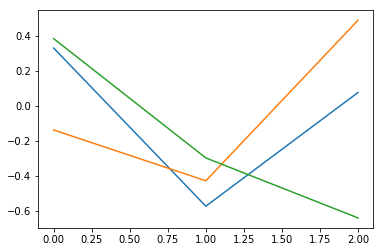

In [173]:
plt.plot(np.squeeze(true_hmm.observations.As[1,:,:]));

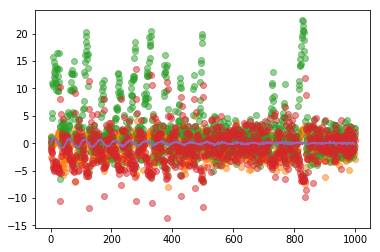

In [174]:
plt.plot(z)
plt.plot(y,'o',alpha=0.5)
plt.plot(inpt)

([<matplotlib.axis.YTick at 0x1a293944a8>,
 <a list of 3 Text yticklabel objects>)

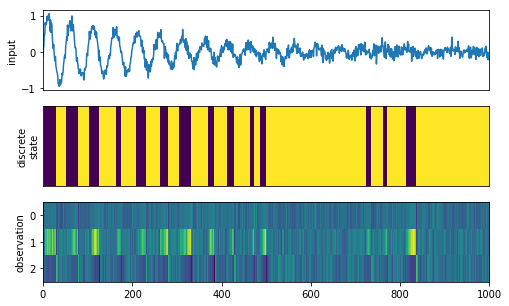

In [175]:
# Plot the data
plt.figure(figsize=(8, 5))

plt.subplot(311)
plt.plot(inpt)
plt.xticks([])
plt.xlim(0, T)
plt.ylabel("input")

plt.subplot(312)
plt.imshow(z[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, T)
plt.ylabel("discrete\nstate")
plt.yticks([])

plt.subplot(313)
#plt.imshow(one_hot(y[:,0], C).T, aspect="auto")
plt.imshow(y.T, aspect="auto")
plt.xlim(0, T)
plt.ylabel("observation")
plt.yticks(np.arange(C))

In [176]:
# Now create a new HMM and fit it to the data with EM
N_iters = 50
# hmm = ssm.HMM(K, D, M=M, 
#           observations="categorical", observation_kwargs=dict(C=C),
#           transitions="inputdriven")
hmm = ssm.HMM(K, D, M=M, 
          observations="autoregressive", transitions="inputdriven")

# Fit
hmm_lps = hmm.fit(y, inputs=inpt, method="em", num_em_iters=N_iters)

/Users/Macintosh/anaconda3/lib/python3.7/site-packages/autograd-1.2-py3.7.egg/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/Macintosh/anaconda3/lib/python3.7/site-packages/autograd-1.2-py3.7.egg/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/Macintosh/anaconda3/lib/python3.7/site-packages/autograd-1.2-py3.7.egg/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multid

In [177]:
# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(z, hmm.most_likely_states(y, input=inpt)))
z_inf = hmm.most_likely_states(y, input=inpt)

Text(0, 0.5, 'Log Probability')

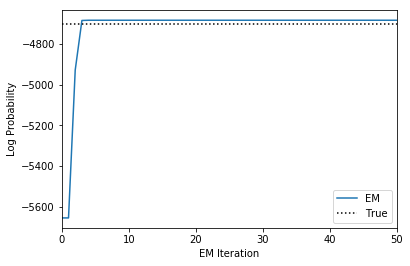

In [178]:
# Plot the log probabilities of the true and fit models
plt.plot(hmm_lps, label="EM")
plt.plot([0, N_iters], true_lp * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, N_iters)
plt.ylabel("Log Probability")

([], <a list of 0 Text yticklabel objects>)

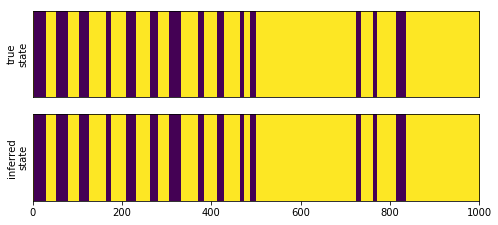

In [179]:
# Plot the true and inferred states
plt.figure(figsize=(8, 3.5))

plt.subplot(211)
plt.imshow(z[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, T)
plt.ylabel("true\nstate")
plt.yticks([])

plt.subplot(212)
plt.imshow(z[None, :], aspect="auto")
plt.xlim(0, T)
plt.ylabel("inferred\nstate")
plt.yticks([])

Text(0.5, 1.0, 'Inferred\nInput Weights')

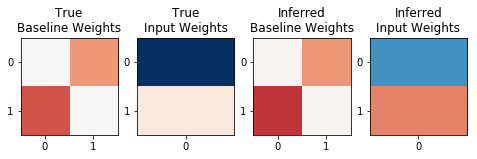

In [180]:
# Plot the true and inferred input effects
plt.figure(figsize=(8, 4))

vlim = max(abs(true_hmm.transitions.log_Ps).max(),
           abs(true_hmm.transitions.Ws).max(),
           abs(hmm.transitions.log_Ps).max(),
           abs(hmm.transitions.Ws).max())

plt.subplot(141)
plt.imshow(true_hmm.transitions.log_Ps, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(K))
plt.yticks(np.arange(K))
plt.title("True\nBaseline Weights")

plt.subplot(142)
plt.imshow(true_hmm.transitions.Ws, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=M/K)
plt.xticks(np.arange(M))
plt.yticks(np.arange(K))
plt.title("True\nInput Weights")

plt.subplot(143)
plt.imshow(hmm.transitions.log_Ps, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(K))
plt.yticks(np.arange(K))
plt.title("Inferred\nBaseline Weights")

plt.subplot(144)
plt.imshow(hmm.transitions.Ws, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=M/K)
plt.xticks(np.arange(M))
plt.yticks(np.arange(K))
plt.title("Inferred\nInput Weights")

array([[[-1.19276461],
        [-0.20487651],
        [-0.35882895]],

       [[ 0.6034716 ],
        [-1.66478853],
        [-0.70017904]]])

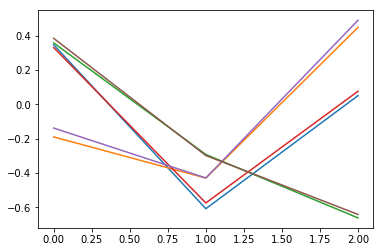

In [185]:
plt.plot(np.squeeze(hmm.observations.As[1,:,:]))
plt.plot(np.squeeze(true_hmm.observations.As[1,:,:]))
true_hmm.observations.Vs

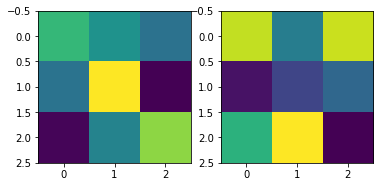

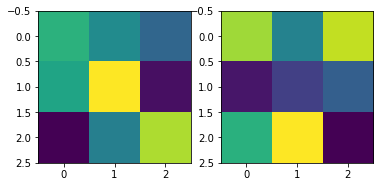

In [184]:
### AR transition matrix

plt.subplot(121)
plt.imshow(np.squeeze(hmm.observations.As[0,:,:]))
plt.subplot(122)
plt.imshow(np.squeeze(hmm.observations.As[1,:,:]))

plt.figure()
plt.subplot(121)
plt.imshow(np.squeeze(true_hmm.observations.As[0,:,:]))
plt.subplot(122)
plt.imshow(np.squeeze(true_hmm.observations.As[1,:,:]))